# Setup

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [4]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'mobilenetv2SoftAtt_10split_LRStr.hdf5'

In [5]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet_v2.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [6]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [7]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [8]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [9]:
any(elem is None for elem in train_img_lst)

False

In [10]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [11]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [12]:
any(elem is None for elem in val_img_lst)

False

In [13]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [14]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [15]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [16]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [17]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [18]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [19]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [20]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [21]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = MobileNetV2.input

# Exclude the last 28 layers of the model.
MobileNetV2_output = MobileNetV2.layers[-28].output

## Final Model

In [22]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(MobileNetV2_output.shape[-1]),name='soft_attention')(MobileNetV2_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
MobileNetV2_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(MobileNetV2_output))

MobileNetV2_output = layers.Concatenate()([MobileNetV2_output, attention_layer])
MobileNetV2_output = Activation('relu')(MobileNetV2_output)
MobileNetV2_output = Dropout(0.5)(MobileNetV2_output)

In [23]:
output = Flatten()(MobileNetV2_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 soft_attention (SoftAttention)  [(None, 7, 7, 960),  138256     ['block_14_depthwise[0][0]']     
                                 (None, 16, 7, 7)]                                                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 960)   0           ['block_14_depthwise[0][0]']     
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 4, 4, 960)    0           ['soft_attention[0][0]']         
                                                                                                  
 sex (Inpu

## Training

In [25]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [26]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [27]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [28]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [30]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 563s 560ms/step - loss: 3.2910 - accuracy: 0.4182 - val_loss: 6.9372 - val_accuracy: 0.1466 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 482s 538ms/step - loss: 1.8578 - accuracy: 0.5173 - val_loss: 32.7195 - val_accuracy: 0.0884 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 484s 540ms/step - loss: 2.0712 - accuracy: 0.5314 - val_loss: 6.5779 - val_accuracy: 0.6546 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 488s 545ms/step - loss: 1.5660 - accuracy: 0.5790 - val_loss: 5.1794 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 493s 551ms/step - loss: 1.5064 - accuracy: 0.5996 - val_loss: 1.9450 - val_accuracy: 0.6034 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 493s 550ms/step - loss: 0.7457 - accuracy: 0.6790 - val_loss: 1.1118 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 7/500
896/896 [==================

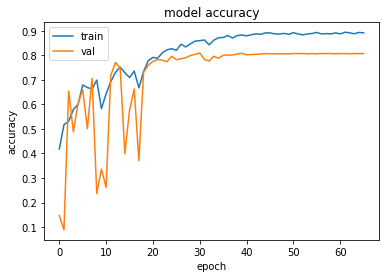

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

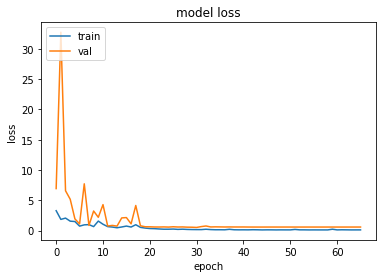

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from tensorflow.keras import models
model.load_weights(model_path)

In [34]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [35]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.70      0.68        33
         bcc       0.72      0.86      0.79        51
         bkl       0.60      0.72      0.66       109
          df       0.82      0.75      0.78        12
         mel       0.50      0.58      0.54       111
          nv       0.94      0.86      0.90       666
        vasc       0.78      1.00      0.88        14

    accuracy                           0.81       996
   macro avg       0.72      0.78      0.74       996
weighted avg       0.83      0.81      0.82       996



# Confusion Matrix Metrics

In [36]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [37]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [38]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[951  12]
 [ 10  23]]
True Positive of akiec: 23
False Positive of akiec: 12
False Negative of akiec: 10
True Negative of akiec: 951
Sensitivity of akiec: 0.696969696969697
Specificity of akiec: 0.9875389408099688
Precision of akiec: 0.6571428571428571
Accuracy of akiec: 0.9779116465863453
Balanced Accuracy of akiec : 0.8422543188898329
F1 Score of akiec: 0.6764705882352942


### bcc       

In [39]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[928  17]
 [  7  44]]
True Positive of bcc: 44
False Positive of bcc: 17
False Negative of bcc: 7
True Negative of bcc: 928
Sensitivity of bcc: 0.8627450980392157
Specificity of bcc: 0.982010582010582
Precision of bcc: 0.7213114754098361
Accuracy of bcc: 0.9759036144578314
Balanced Accuracy of bcc : 0.9223778400248989
F1 Score of bcc: 0.7857142857142857


### bkl

In [40]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[834  53]
 [ 30  79]]
True Positive of bkl: 79
False Positive of bkl: 53
False Negative of bkl: 30
True Negative of bkl: 834
Sensitivity of bkl: 0.7247706422018348
Specificity of bkl: 0.9402480270574972
Precision of bkl: 0.5984848484848485
Accuracy of bkl: 0.9166666666666666
Balanced Accuracy of bkl : 0.832509334629666
F1 Score of bkl: 0.6556016597510373


### df 

In [41]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[982   2]
 [  3   9]]
True Positive of df: 9
False Positive of df: 2
False Negative of df: 3
True Negative of df: 982
Sensitivity of df: 0.75
Specificity of df: 0.9979674796747967
Precision of df: 0.8181818181818182
Accuracy of df: 0.9949799196787149
Balanced Accuracy of df : 0.8739837398373984
F1 Score of df: 0.782608695652174


### mel

In [42]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[821  64]
 [ 47  64]]
True Positive of mel: 64
False Positive of mel: 64
False Negative of mel: 47
True Negative of mel: 821
Sensitivity of mel: 0.5765765765765766
Specificity of mel: 0.927683615819209
Precision of mel: 0.5
Accuracy of mel: 0.8885542168674698
Balanced Accuracy of mel : 0.7521300961978927
F1 Score of mel: 0.5355648535564853


### nv

In [43]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[292  38]
 [ 93 573]]
True Positive of nv: 573
False Positive of nv: 38
False Negative of nv: 93
True Negative of nv: 292
Sensitivity of nv: 0.8603603603603603
Specificity of nv: 0.8848484848484849
Precision of nv: 0.9378068739770867
Accuracy of nv: 0.8684738955823293
Balanced Accuracy of nv : 0.8726044226044226
F1 Score of nv: 0.8974158183241974


### vasc

In [44]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[978   4]
 [  0  14]]
True Positive of vasc: 14
False Positive of vasc: 4
False Negative of vasc: 0
True Negative of vasc: 978
Sensitivity of vasc: 1.0
Specificity of vasc: 0.9959266802443992
Precision of vasc: 0.7777777777777778
Accuracy of vasc: 0.9959839357429718
Balanced Accuracy of vasc : 0.9979633401221997
F1 Score of vasc: 0.875


## Weighted, Macro, Micro, ROC AUC

In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8278051172613201
Recall: 0.8092369477911646
Accuracy: 0.8092369477911646
weighted Roc score: 0.9498282307723837


In [46]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7158150929963177
Recall: 0.7816317677353836
Accuracy: 0.8092369477911646
Macro Roc score: 0.9662702397546762


In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8092369477911646
Recall: 0.8092369477911646
Accuracy: 0.8092369477911646
Micro Roc score: 0.9792278215942753


In [48]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9727492998521037
The ROC AUC score of bcc is: 0.9880485527544351
The ROC AUC score of bkl is: 0.9483880309878676
The ROC AUC score of df is: 0.997120596205962
The ROC AUC score of mel is: 0.9064793607166488
The ROC AUC score of nv is: 0.9513240513240513
The ROC AUC score of vasc is: 0.9997817864416643


In [49]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

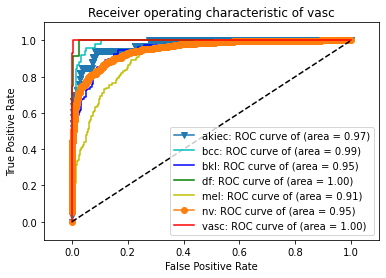

In [50]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()